# Red Dead Redemption 2 크롤링

1. 게임 전체 리뷰
    - 수집 대상
        - 닉네임, 작성일, 본문, 추천 여부, 플레이 시간
    - 스크롤 내리면서 리뷰 한 개 섹션 단위로 파싱
    - 중복된 댓글 반복 시 종료
    - 500개마다 중간저장
    
2. 스팀 뉴스 업데이트 수집
    - 수집 대상
        - 업데이트 페이지에서 각 세부 페이지 경로 수집
        - 이후 제목, 게시일, 유형, 본문, 좋아요 수, 댓글 주소 수집

## 1. 게임 전체 리뷰

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd

# 셀레니움 설정
options = Options()
options.add_argument("--start-maximized")
options.add_experimental_option("detach", True)

driver = webdriver.Chrome(options=options)

# URL 진입
url = "https://steamcommunity.com/app/1174180/reviews/?p=1&browsefilter=trendthreemonths&filterLanguage=all"
driver.get(url)
time.sleep(3)

SCROLL_PAUSE = 2
results = []
last_height = driver.execute_script("return document.body.scrollHeight")
last_seen_content = None
seen_repeat_count = 0

save_interval = 500
save_count = 1

while True:
    # 리뷰 카드 수집
    cards = driver.find_elements(By.CLASS_NAME, "apphub_Card")

    for card in cards[len(results):]:
        try:
            nickname_link = card.find_element(By.CSS_SELECTOR, ".apphub_friend_block_container a").get_attribute("href")
        except:
            nickname_link = None

        try:
            date = card.find_element(By.CLASS_NAME, "date_posted").text.replace("게시 일시: ", "").strip()
        except:
            date = None

        try:
            content = card.find_element(By.CLASS_NAME, "apphub_CardTextContent").text.strip()
        except:
            content = None

        try:
            recommendation = card.find_element(By.CLASS_NAME, "title").text.strip()
        except:
            recommendation = None

        try:
            playtime = card.find_element(By.CLASS_NAME, "hours").text.strip()
        except:
            playtime = None

        # 종료 조건: 동일 댓글 반복 감지
        if content == last_seen_content:
            seen_repeat_count += 1
            if seen_repeat_count >= 3:
                print("\n동일 댓글 3회 반복 감지. 크롤링 종료.")
                break
        else:
            seen_repeat_count = 0
            last_seen_content = content

        row = {
            "닉네임": nickname_link,
            "작성일": date,
            "본문": content,
            "추천 여부": recommendation,
            "플레이 시간": playtime
        }
        results.append(row)

        # 실시간 출력
        print(f"\n닉네임: {nickname_link}")
        print(f"작성일: {date}")
        print(f"추천여부: {recommendation}")
        print(f"플레이 시간: {playtime}")
        print(f"본문: {content[:100]}{'...' if content and len(content) > 100 else ''}")

        # 중간 저장
        if len(results) % save_interval == 0:
            temp_df = pd.DataFrame(results)
            temp_df.to_csv(f"RDR2_reviews_temp_{save_count}.csv", index=False, encoding="utf-8-sig")
            print(f"\n 중간 저장 완료: RDR2_reviews_temp_{save_count}.csv ({len(results)}개)")
            save_count += 1

    # 중복 종료 처리
    if seen_repeat_count >= 3:
        break

    # 스크롤 다운
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5)  # 스크롤 후 3초 대기

    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        print("\n더 이상 로드할 내용 없음. 종료합니다.")
        break
    last_height = new_height


# 최종 저장
df = pd.DataFrame(results)
df.to_csv("31-0. RDR2_reviews.csv", index=False, encoding="utf-8-sig")
print(f"\n 크롤링 완료! 총 리뷰 수: {len(df)}개")
print("저장 완료: 31-0. RDR2_reviews.csv")

## 2. 스팀 뉴스 업데이트 수집

In [7]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import pandas as pd

# ▶ URL 설정
url = "https://store.steampowered.com/news/app/1174180?updates=true"

# ▶ 드라이버 설정
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ▶ 페이지 열기
driver.get(url)
time.sleep(3)

# ▶ 수집용 set
collected_urls = set()
results = []

# ▶ 천천히 스크롤하며 수집
scroll_count = 0
max_scrolls = 50
no_new_count = 0

while scroll_count < max_scrolls and no_new_count < 3:
    soup = BeautifulSoup(driver.page_source, "html.parser")

    news_blocks = soup.find_all("div", class_="_398u23KF15gxmeH741ZSyL")

    found_this_round = 0

    for block in news_blocks:
        a_tag = block.find("a", class_="Focusable")
        if a_tag:
            href = a_tag.get("href")
            if href and href not in collected_urls:
                full_url = "https://store.steampowered.com" + href
                collected_urls.add(href)
                results.append({"링크": full_url})
                print(f"📝 [{len(results)}] {full_url}")
                found_this_round += 1

    if found_this_round == 0:
        no_new_count += 1
    else:
        no_new_count = 0

    # 스크롤 다운
    driver.execute_script("window.scrollBy(0, 1500);")
    scroll_count += 1
    time.sleep(2.5)

# ▶ 저장
updatelink_df = pd.DataFrame(results)
updatelink_df['링크'] = updatelink_df["링크"].str.extract(r"(\/view\/\d+)")
updatelink_df.to_csv("31-1. RDR2_links.csv", index=False, encoding="utf-8-sig")
print(f"\n✅ 총 {len(updatelink_df)}개 뉴스 링크 저장 완료 → 31-1. RDR2_links.csv.csv")

driver.quit()


📝 [1] https://store.steampowered.com/news/app/1174180/view/2718437657217765528
📝 [2] https://store.steampowered.com/news/app/1174180/view/1718616979105906559
📝 [3] https://store.steampowered.com/news/app/1174180/view/501708794524337021
📝 [4] https://store.steampowered.com/news/app/1174180/view/501706257131899192
📝 [5] https://store.steampowered.com/news/app/1174180/view/501703086540064072
📝 [6] https://store.steampowered.com/news/app/1174180/view/501701175839555750
📝 [7] https://store.steampowered.com/news/app/1174180/view/501697399294525975
📝 [8] https://store.steampowered.com/news/app/1174180/view/501695476544831777
📝 [9] https://store.steampowered.com/news/app/1174180/view/532092880811983031
📝 [10] https://store.steampowered.com/news/app/1174180/view/514075305730637899
📝 [11] https://store.steampowered.com/news/app/1174180/view/514072769031307365
📝 [12] https://store.steampowered.com/news/app/1174180/view/4447961335474421776
📝 [13] https://store.steampowered.com/news/app/1174180/vie

In [8]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time

# ▶ 드라이버 세팅
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ▶ URL 베이스
base_url = "https://store.steampowered.com/news/app/1174180"

# ▶ update_df["링크"]에 '/view/숫자' 형태가 들어있다고 가정
# 예시용 (실제에는 update_df = pd.read_csv(...)로 불러와야 함)
# update_df = pd.read_csv("steam_news_links_stable.csv")
# update_df["링크"] = update_df["링크"].str.extract(r"(\/view\/\d+)")

results = []

for i, update_link in enumerate(updatelink_df["링크"], 1):
    full_url = base_url + update_link
    print(f"\n🌐 [{i}] 크롤링 중: {full_url}")

    try:
        driver.get(full_url)
        time.sleep(3)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # ✅ 제목
        title_tag = soup.select_one("div._3z2NYCkFizMu4fMvWTIBUG div.TqEPC9bhvVpZ1rb3Z8Mbd")
        title = title_tag.text.strip() if title_tag else ""

        # ✅ 게시일
        date_tag = soup.select_one("div._3IxVZE9uydjh3cA9kmtnk7 div._2KsEbGy9kiSDeQpcqEc9DG div._1Maw_Rw6sOKYC1KkOI1xM")
        date = date_tag.text.strip() if date_tag else ""

        # ✅ 유형
        type_tag = soup.select_one("div._3phfIcOe_STA7hSoFfIxlE")
        type_text = type_tag.text.strip() if type_tag else ""

        # ✅ 본문
        body_tag = soup.select_one("div.EventDetailsBody.A_A2B6fTn_MPLlGCmsLtd")
        body = body_tag.text.strip() if body_tag else ""

        # ✅ 좋아요 수
        like_tag = soup.select_one("div._9x4Z7eMgdwfAVMr16ZaJ0 div._3Kelh1-_v6xHfRjF68n7NB div._3csl-MPe-hKuT8hQpOqEG5")
        likes = like_tag.text.strip() if like_tag else ""

        # ✅ 토론 주소
        comment_tag = soup.select_one("div._16xC0mtOWoLbvSQbmo_ycv a.Focusable")
        comment_link = comment_tag["href"] if comment_tag else ""

        # ▶ 저장
        results.append({
            "링크": full_url,
            "제목": title,
            "게시일": date,
            "유형": type_text,
            "본문": body,
            "좋아요": likes,
            "댓글 주소": comment_link
        })

        print(f"📝 제목: {title} | 게시일: {date} | 좋아요: {likes} | 본문: {body[:20]}")

    except Exception as e:
        print(f"❌ [{i}] 오류 발생: {e}")
        continue

driver.quit()

# ▶ DataFrame 저장
update_df = pd.DataFrame(results)
update_df.to_csv("31-2. RDR2_update_details.csv", index=False, encoding="utf-8-sig")
print(f"\n✅ 총 {len(update_df)}개 뉴스 상세 정보 저장 완료 → 31-2. RDR2_update_details.csv")


🌐 [1] 크롤링 중: https://store.steampowered.com/news/app/1174180/view/2718437657217765528
📝 제목: Red Dead Online: The Naturalist Now Available | 게시일: Posted Wed, July 29, 2020 @9:15 AM KST | 좋아요: 12,256 | 본문: Track, hunt and stud

🌐 [2] 크롤링 중: https://store.steampowered.com/news/app/1174180/view/1718616979105906559
📝 제목: Red Dead Online: Moonshiners | 게시일: Posted Sat, December 14, 2019 @4:56 AM KST | 좋아요: 7,133 | 본문: Peddle white lightni

🌐 [3] 크롤링 중: https://store.steampowered.com/news/app/1174180/view/501708794524337021
📝 제목: Discover Rare Collectibles in Red Dead Online and Unearth Bonuses | 게시일: StartedTue, September 2, 2025 11:19 PM KST | 좋아요: 2,285 | 본문: The peaks and valley

🌐 [4] 크롤링 중: https://store.steampowered.com/news/app/1174180/view/501706257131899192
📝 제목: Deliver Justice as a Bounty Hunter to Earn Bonuses and Discounts | 게시일: Past Event StartedWed, August 6, 2025 4:23 PM KST | 좋아요: 4,312 | 본문: Bring fugitives to j

🌐 [5] 크롤링 중: https://store.steampowered.com/news/app/117418

# 정제

In [1]:
import pandas as pd

### 인스타

In [2]:
ds_insta = pd.read_csv('30-3. destiny2_instagram_crawled.csv', encoding='utf-8-sig')

In [5]:
ds_insta = ds_insta.sort_values(by='게시일', ascending=True)

In [8]:
ds_insta['좋아요 수'] = ds_insta['좋아요 수'].str.replace('좋아요', '', regex=False).str.strip()

In [10]:
ds_insta['좋아요 수'] = ds_insta['좋아요 수'].str.replace('개', '', regex=False).str.strip()

In [12]:
def convert_likes(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    if '만' in val:
        num = float(val.replace('만', ''))
        return int(num * 10000)
    return int(val.replace(',', ''))

In [13]:
ds_insta['좋아요 수'] = ds_insta['좋아요 수'].apply(convert_likes)

In [45]:
ds_insta.to_csv('30-3-1. destiny2_instagram_정제.csv', index=False, encoding="utf-8-sig")

---

### 유튜브

In [18]:
ds_yt = pd.read_csv('30-4. destiny2_youtube_crawled.csv', encoding='utf-8-sig')

In [20]:
ds_yt.head()

,제목,URL,조회수,게시일
0,Destiny 2: The Edge of Fate | Shooting Range H...,https://www.youtube.com/watch?v=fl8l_D5gELk,조회수 1.8만회,1개월 전
1,Destiny 2: The Edge of Fate Original Soundtrac...,https://www.youtube.com/watch?v=wvr5e-cBxyo,조회수 4.3천회,1개월 전
2,Destiny 2: The Edge of Fate Original Soundtrac...,https://www.youtube.com/watch?v=ujvkFYMUu4E,조회수 4.5천회,1개월 전
3,Destiny 2: The Edge of Fate Original Soundtrac...,https://www.youtube.com/watch?v=skLNpqcLkck&pp...,조회수 5.4천회,1개월 전
4,Destiny 2: The Edge of Fate Original Soundtrac...,https://www.youtube.com/watch?v=sV0B7WJiBg0,조회수 2.5천회,1개월 전


In [22]:
ds_yt = ds_yt[~ds_yt['제목'].str.contains('soundtrack', case=False, na=False)]

In [24]:
ds_yt = ds_yt[ds_yt['제목'].str.contains('데스티니 가디언즈', case=False, na=False)]

In [26]:
ds_yt.head()

,제목,URL,조회수,게시일
22,데스티니 가디언즈: 이단 | 길을 따라가다 시네마틱,https://www.youtube.com/watch?v=Pjcdp6QohWg,조회수 11만회,1개월 전
26,데스티니 가디언즈: 운명의 경계 개발자 생각 | 통제권 장악 [KO],https://www.youtube.com/watch?v=x9qeEL8PVLU,조회수 1천회,1개월 전
39,데스티니 가디언즈: 운명의 경계 | 개발자 라이브 스트리밍 II 요약 [KO],https://www.youtube.com/watch?v=v912v6xi38M,조회수 1.1천회,1개월 전
62,데스티니 가디언즈: 운명의 경계 | 출시 트레일러 [KO],https://www.youtube.com/watch?v=6zfm4hFjj9M,조회수 6.3천회,1개월 전
67,데스티니 가디언즈: 운명의 경계 개발자 생각 | 케플러의 미스터리 [KO],https://www.youtube.com/watch?v=knxyn_Kn0Yg,조회수 517회,1개월 전


In [31]:
ds_yt['조회수'] = ds_yt['조회수'].str.replace('조회수', '', regex=False).str.strip()

In [33]:
ds_yt['조회수'] = ds_yt['조회수'].str.replace('회', '', regex=False).str.strip()

In [37]:
def convert_view(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    if '만' in val:
        num = float(val.replace('만', ''))
        return int(num * 10000)
    if '천' in val:
        num = float(val.replace('천', ''))
        return int(num * 1000)
    return int(val.replace(',', ''))

In [38]:
ds_yt['조회수'] = ds_yt['조회수'].apply(convert_view)

In [ ]:
from datetime import datetime, timedelta
import re

def convert_relative_date(val):
    if pd.isna(val):
        return None
    
    # '좋아요' 제거 및 공백 정리
    val = str(val).replace('좋아요', '').strip()
    
    today = datetime.today()
    
    # '개월 전'
    m = re.match(r'(\d+)\s*개월\s*전', val)
    if m:
        months = int(m.group(1))
        # 월 단위 계산 (단순히 30일로 환산)
        return (today - timedelta(days=months * 30)).strftime('%Y-%m-%d')
    
    # '일 전'
    d = re.match(r'(\d+)\s*일\s*전', val)
    if d:
        days = int(d.group(1))
        return (today - timedelta(days=days)).strftime('%Y-%m-%d')
    
    # '시간 전'
    h = re.match(r'(\d+)\s*시간\s*전', val)
    if h:
        hours = int(h.group(1))
        return (today - timedelta(hours=hours)).strftime('%Y-%m-%d')
    
    # 이미 날짜 형태인 경우
    try:
        return pd.to_datetime(val).strftime('%Y-%m-%d')
    except:
        return val

# 적용
ds_yt['게시일'] = ds_yt['게시일'].apply(convert_relative_date)

In [44]:
ds_yt.to_csv('30-4-1. destiny2_youtube_정제.csv', index=False, encoding="utf-8-sig")

---

### 통리뷰

In [46]:
ds_reviews = pd.read_csv('30-0. destiny2_reviews.csv', encoding="utf-8-sig")

In [48]:
ds_reviews["닉네임"] = ds_reviews["닉네임"].str.replace("https://steamcommunity.com/", "", regex=False)

In [49]:
ds_reviews["작성일"] = ds_reviews["작성일"].str.replace("Posted: ", "", regex=False)

In [50]:
import re

ds_reviews["닉네임"] = ds_reviews["닉네임"].str.extract(r'(?:id/|profiles/)([^/]+)')

In [51]:
ds_reviews["본문"] = ds_reviews["본문"].str.replace(r'^Posted:.*?\n', '', regex=True)

In [ ]:
ds_reviews

In [54]:
ds_reviews['작성일'] = pd.to_datetime(ds_reviews['작성일'] + ' 2025', errors='coerce').dt.strftime('%Y-%m-%d')

In [56]:
ds_reviews['추천 여부'] = ds_reviews['추천 여부'].replace({'Not Recommended': 0, 'Recommended': 1})

C:\Users\user\AppData\Local\Temp\ipykernel_3468\3299187979.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ds_reviews['추천 여부'] = ds_reviews['추천 여부'].replace({'Not Recommended': 0, 'Recommended': 1})


In [58]:
ds_reviews["플레이 시간"] = ds_reviews["플레이 시간"].str.replace(" on record", "", regex=False)

In [62]:
from googletrans import Translator
import time

# 번역기 초기화
translator = Translator()

# 번역 결과 저장
translated_results = []

for idx, row in ds_reviews.iterrows():
    text = row["본문"]

    if pd.isna(text) or not str(text).strip():
        translated_text = ""
    else:
        try:
            result = translator.translate(text, src='auto', dest='en')
            translated_text = result.text.strip()
        except Exception as e:
            print(f"[에러] {idx}번 번역 실패: {e}")
            translated_text = "[번역 실패]"
    
    print(f"{idx+1}/{len(ds_reviews)} | {row['닉네임']} → {translated_text}")
    translated_results.append(translated_text)

    time.sleep(0.5)  # API 차단 방지 대기

# ds_reviews에 바로 열 추가
ds_reviews["본문_번역"] = translated_results

# 전체 DataFrame 저장
ds_reviews.to_csv("30-0-1. destiny2_reviews_정제.csv", index=False, encoding='utf-8-sig')
print("번역 열 추가 및 저장 완료 → 30-0-1. destiny2_reviews_정제.csv")


1/2500 | 76561198113955857 → The vast majority of the content I have paid for no longer exists in the game.

Let me say that again:
THE VAST MAJORITY OF THE CONTENT I HAVE PAID REAL WORLD MONEY FOR NO LONGER EXISTS IN THE GAME

There is literally no excusing this. I do not care what anyone could say to defend this game. From a vet who has put up with Bungie's crap for a while now, DO. NOT. PLAY. THIS. GAME.

Edit: Because the white knights of Bungie, defenders from legitimate criticism have arrived, I'll make myself even more clear:
THE VAST MAJORITY OF THE CONTENT I HAVE PAID REAL WORLD MONEY FOR NO LONGER EXISTS IN THE GAME. THIS IS INEXCUSABLE, AND HAD ANY OTHER COMPANY DONE THIS WITHOUT A PRE-ESTABLISHED BASE OF ADDICTED PLAYERS WHO HAVE SUNK COSTED THEMSELVES INTO IGNORING EVERY SINGLE PROBLEM THE GAME HAS, THAT COMPANY WOULD BE BANKRUPT WITHIN A MONTH

If the literal worst possible business practice a gaming company could commit to its users is somehow still not enough for you, h

- 통리뷰 긍부정 키워드 워드클라우드

In [63]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [72]:
ds_reviews = pd.read_csv("30-0-1. destiny2_reviews_정제.csv", encoding='utf-8-sig')

In [80]:
ds_reviews = ds_reviews[ds_reviews['본문_번역'] != '[번역 실패]']

In [64]:
# VADER 준비 (최초 1회만 필요)
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [87]:
def vader_label(text):
    comp = sia.polarity_scores(str(text))['compound']
    if comp >= 0.05:
        return 'positive'
    elif comp < -0.05:
        return 'negative'
    else:
        return 'neutral'

In [88]:
# 약라벨 컬럼 생성
ds_reviews['vader_label'] = ds_reviews['본문_번역'].apply(vader_label)
ds_reviews['compound'] = ds_reviews['본문_번역'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

In [89]:
ds_reviews.head()

,닉네임,작성일,본문,추천 여부,플레이 시간,본문_번역,vader_label,compound
0,76561198113955857,2025-07-12,The vast majority of the content I have paid f...,0,"1,658.4 hrs",The vast majority of the content I have paid f...,negative,-0.9446
1,76561198960596025,2025-06-19,现在还能忍住棒鸡的骚操作，并且预购年八的，我愿称之为吃屎大王,0,"1,873.4 hrs",Now I can still hold back the slutty operation...,negative,-0.2023
2,76561198333992013,2025-07-24,命运2还是太权威了，史上最神人的游戏，建议生活顺利的玩家都玩一下这个体验一下人生疾苦,1,"3,121.4 hrs","Destiny 2 is still too authoritative, the most...",neutral,-0.0258
4,Archduke_of_hell,2025-06-11,"If you were interested in this game, then i'm ...",0,352.4 hrs,"If you were interested in this game, then i'm ...",positive,0.9861
6,76561198063289460,2025-06-28,After playing this game for years I managed to...,0,"1,732.9 hrs",After playing this game for years I managed to...,positive,0.9867


In [90]:
ds_reviews = ds_reviews.dropna(subset=["본문_번역"]).reset_index(drop=True)

In [91]:
ds_pn = ds_reviews[['닉네임', '본문_번역','vader_label','compound']]

In [92]:
# 절대값이 작은 샘플은 제거해서 신뢰도를 높임
ds_pn = ds_pn[ds_pn["compound"].abs() >= 0.2].reset_index(drop=True)

In [93]:
# neutral 라벨 제거 - 긍정/부정만 남은 이진 분류 전용 데이터프레임을 만듦
bin_df = ds_pn[ds_pn["vader_label"] != "neutral"].reset_index(drop=True)

In [94]:
# 데이터 긍/부정 비율 확인
print(bin_df["vader_label"].value_counts())

vader_label
positive    1041
negative     828
Name: count, dtype: int64


In [100]:
bin_df

,닉네임,본문_번역,vader_label,compound
0,76561198113955857,The vast majority of the content I have paid f...,negative,-0.9446
1,76561198960596025,Now I can still hold back the slutty operation...,negative,-0.2023
2,Archduke_of_hell,"If you were interested in this game, then i'm ...",positive,0.9861
3,76561198063289460,After playing this game for years I managed to...,positive,0.9867
4,hurmrock,"He played the game before appearing in Steam, ...",positive,0.3182
...,...,...,...,...
1864,76561198827197612,Since I play this game I have been having my a...,positive,0.6486
1865,76561198148680136,Fantastic sci-fi online rpg. I had a lot of fu...,positive,0.9060
1866,76561198437384834,Great game.\n\ncame from destiny 1 on the xbox...,positive,0.9827
1867,76561198206991175,Still one of my absolute favorite games.Clearl...,positive,0.8100


In [102]:
# 사용할 데이터프레임 선택 (vader_label 열이 있어야 함)
if 'df_filt' in globals() and isinstance(bin_df, pd.DataFrame):
    use_df = bin_df
elif 'ds_pn' in globals() and isinstance(ds_pn, pd.DataFrame):
    use_df = ds_pn
else:
    raise ValueError("vader_label 열이 포함된 DataFrame(df_filt 또는 ds_pn)이 필요합니다.")

# 긍정 / 부정 텍스트 리스트 추출
pos_texts = use_df.loc[use_df['vader_label'] == 'positive', '본문_번역'].dropna().tolist()
neg_texts = use_df.loc[use_df['vader_label'] == 'negative', '본문_번역'].dropna().tolist()

print(f"긍정 문장 개수: {len(pos_texts)}")
print(f"부정 문장 개수: {len(neg_texts)}")

긍정 문장 개수: 1041
부정 문장 개수: 828


In [103]:
# TF-IDF로 상위 키워드 뽑기 (uni/bi-gram)
# Term Frequency,단어 빈도/ Inverse Document Frequency, 역문서 빈도
# 자주 나오지만 흔하지 않은 단어 → 높은 점수
# 자주 나오지만 흔한 단어 → 낮은 점수
from sklearn.feature_extraction.text import TfidfVectorizer

def top_keywords(texts, topk=30, ngram=(1,2)):
    if not texts:
        return []
    vec = TfidfVectorizer(
        max_features=20000,
        ngram_range=ngram,
        stop_words='english'  # 불용어 자동 제거
    )
    X = vec.fit_transform(texts)
    vocab = vec.get_feature_names_out()
    # 각 피처의 평균 TF-IDF 점수로 랭킹
    scores = X.mean(axis=0).A1
    order = scores.argsort()[::-1][:topk]
    return [(vocab[i], float(scores[i])) for i in order]

pos_kw = top_keywords(pos_texts, topk=100, ngram=(1,2))
neg_kw = top_keywords(neg_texts, topk=100, ngram=(1,2))

print("POS top 5:", pos_kw[:5])
print("NEG top 5:", neg_kw[:5])

POS top 5: [('game', 0.056911335072845605), ('good', 0.03801135466639967), ('play', 0.028384353976546144), ('fun', 0.028261034076581402), ('like', 0.0240062214745695)]
NEG top 5: [('game', 0.04846331782846334), ('bad', 0.02191365430231086), ('play', 0.02020232243368374), ('don', 0.01516097234142765), ('just', 0.015150657630666024)]


In [104]:
# 키워드 한글 번역 (무료 번역기 예시)

from deep_translator import MyMemoryTranslator

translator = MyMemoryTranslator(source='english', target='korean')

def translate_list(pairs):
    # pairs: [(keyword, score), ...]
    out = []
    for w, s in pairs:
        try:
            ko = translator.translate(w)
        except Exception:
            ko = ""  # 실패 시 빈 문자열
        out.append((w, ko, s))
    return out

pos_kw_ko = translate_list(pos_kw)
neg_kw_ko = translate_list(neg_kw)

# 미리보기
for w, ko, sc in pos_kw_ko[:10]:
    print(f"[POS] {w} -> {ko} ({sc:.4f})")
for w, ko, sc in neg_kw_ko[:10]:
    print(f"[NEG] {w} -> {ko} ({sc:.4f})")

[POS] game -> 게임을 (0.0569)
[POS] good -> 선 (0.0380)
[POS] play -> 플레이 (0.0284)
[POS] fun -> 재밌는 (0.0283)
[POS] like -> 좋아요 (0.0240)
[POS] destiny -> taewanmi (0.0209)
[POS] content -> 만족 (0.0177)
[POS] time -> 시간 (0.0172)
[POS] free -> 무료 (0.0158)
[POS] new -> 새 (0.0155)
[NEG] game -> 게임을 (0.0485)
[NEG] bad -> 나쁨 (0.0219)
[NEG] play -> 플레이 (0.0202)
[NEG] don -> 돈 (0.0152)
[NEG] just -> 오직 (0.0152)
[NEG] new -> 새 (0.0151)
[NEG] bungie -> 벙기 (0.0147)
[NEG] shit -> 염병 (0.0144)
[NEG] content -> 만족 (0.0139)
[NEG] destiny -> taewanmi (0.0136)


In [105]:
pos_df_kw = pd.DataFrame(pos_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])
neg_df_kw = pd.DataFrame(neg_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])

pos_df_kw.to_csv("30-5.데스티니2_긍정단어.csv", index=False, encoding="utf-8-sig")
neg_df_kw.to_csv("30-5.데스티니2_부정단어.csv", index=False, encoding="utf-8-sig")

print("✅ 저장 완료: 30-5.데스티니2_긍정단어.csv / 30-5.데스티니2_부정단어.csv")

✅ 저장 완료: 30-5.데스티니2_긍정단어.csv / 30-5.데스티니2_부정단어.csv


In [116]:
pos_df_kw = pd.read_csv("30-5.데스티니2_긍정단어.csv", encoding="utf-8-sig")
neg_df_kw = pd.read_csv("30-5.데스티니2_부정단어.csv", encoding="utf-8-sig")

In [119]:
pos_df_kw[51:100]

,keyword_en,keyword_ko,tfidf_mean
51,save,저장하기,0.005988
52,long,긴,0.005779
53,say,말하다,0.005682
54,things,것,0.005609
55,come,스리랑카,0.005586
56,think,생각하다,0.005529
57,worth,가치,0.005470
58,life,인생,0.005439
59,gameplay,게임 플레이,0.005426
60,paid,결제 완료,0.005425


In [120]:
pos_df_kw = pos_df_kw.drop([5, 15, 17, 23, 35, 36, 45, 47, 49, 55, 64, 68, 70, 82, 91]).reset_index(drop=True) # 번역이 안되어서 드랍

In [121]:
pos_df_kw[:50]

,keyword_en,keyword_ko,tfidf_mean
0,game,게임을,0.056911
1,good,선,0.038011
2,play,플레이,0.028384
3,fun,재밌는,0.028261
4,like,좋아요,0.024006
5,content,만족,0.017709
6,time,시간,0.017213
7,free,무료,0.015766
8,new,새,0.015478
9,just,오직,0.015058


In [122]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].replace({
    "사랑은 오래 참는다": "사랑",
    "새": "새로운",
    "벙기": "번지",
    "멋져요": "즐겜",
    "층 (cheung)": "스토리",
    "위대한": "대단한",
    "재생 중": "실행 중",
    "재생": "실행",
    "선수": "플레이어"
})

In [123]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_3468\59162243.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


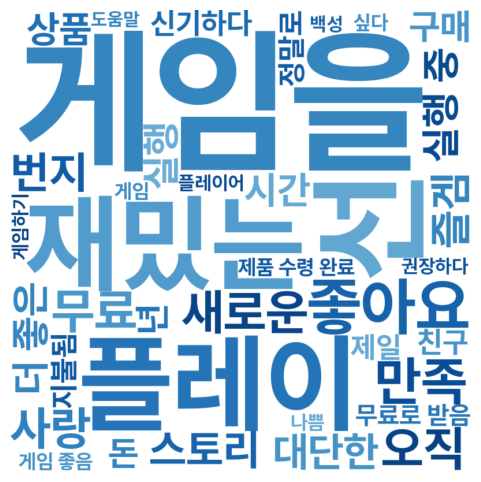

In [124]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
blues = cm.get_cmap("Blues")

def dark_blues(*args, **kwargs):
    return to_hex(blues(random.uniform(0.50, 0.98)))  # 0.70~0.98 구간만 사용(더 진함)

# 폰트 경로 (한글 표시 필수)
fontpath='C:/Users/user/Desktop/fonts/Pretendard-Bold.ttf'


# freq 딕셔너리 만들기
freq_dict = dict(zip(pos_df_kw["keyword_ko"][:40], pos_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path=fontpath,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_blues,
    collocations=False,
    relative_scaling=0.6,
    margin=0
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6 ,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [126]:
neg_df_kw[:50]

,keyword_en,keyword_ko,tfidf_mean
0,game,게임을,0.048463
1,bad,나쁨,0.021914
2,play,플레이,0.020202
3,don,돈,0.015161
4,just,오직,0.015151
5,new,새,0.015073
6,bungie,벙기,0.014721
7,shit,염병,0.014446
8,content,만족,0.013875
9,destiny,taewanmi,0.013614


In [127]:
neg_df_kw = neg_df_kw.drop([3, 9, 16, 17, 24, 35, 40, 42, 47]).reset_index(drop=True) # 번역이 안되어서 드랍

In [128]:
neg_df_kw[:50]

,keyword_en,keyword_ko,tfidf_mean
0,game,게임을,0.048463
1,bad,나쁨,0.021914
2,play,플레이,0.020202
3,just,오직,0.015151
4,new,새,0.015073
5,bungie,벙기,0.014721
6,shit,염병,0.014446
7,content,만족,0.013875
8,time,시간,0.013212
9,hate,증오,0.012902


In [131]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].replace({
    "새": "새로운",
    "벙기": "번지",
    "나귀": "멍청이",
    "재생 중": "실행 중",
    "선수": "플레이어",
    "층(cheung)": "스토리",
    "갈기": "빻다",
    "백성": "사람들",
    "nandigabiwo":"죽다"
})

C:\Users\user\AppData\Local\Temp\ipykernel_3468\440836625.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds  = cm.get_cmap("Reds")


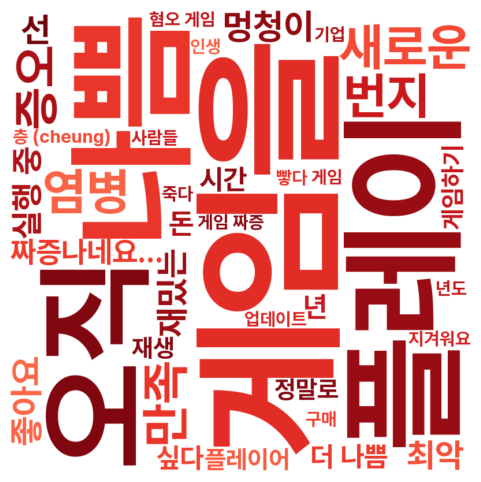

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

reds  = cm.get_cmap("Reds")

def dark_reds(*args, **kwargs):
    return to_hex(reds(random.uniform(0.50, 0.98)))

# 폰트 경로 (한글 표시 필수)
fontpath='C:/Users/user/Desktop/fonts/Pretendard-Bold.ttf'


# freq 딕셔너리 만들기
freq_dict = dict(zip(neg_df_kw["keyword_ko"][:40], neg_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path=fontpath,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_reds,
    collocations=False,
    relative_scaling=0.3
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()